## 使得输出格式统一

我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

请你按照建议修改：

将TCN模型改为LSTM模型，并保持防止过拟合的特性和藻密度特征的权重增强。以下是主要的更改：

```python:root\Download\Modis-algae-aliyun\AlgaeBloomForecast-20241107\08-LSTM-单独计算藻密度-dropout-better+his-density-05.ipynb
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # 特征权重层，为藻密度相关特征赋予更大权重
        initial_weights = torch.ones(input_size)
        density_indices = [i for i, name in enumerate(features) if 'density' in name]
        initial_weights[density_indices] = 2.0  # 藻密度特征权重加倍
        self.feature_weights = nn.Parameter(initial_weights)
        
        # 批归一化层
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向LSTM
        )
        
        # 注意力机制
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)  # *2是因为双向LSTM
        
        # 全连接层，使用多层防止过拟合
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        # 批归一化
        batch_size, seq_len, features = weighted_x.size()
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        weighted_x = weighted_x.transpose(1, 2)
        
        # LSTM处理
        lstm_out, _ = self.lstm(weighted_x)
        
        # 注意力机制
        lstm_out = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.transpose(0, 1)
        
        # 取最后一个时间步
        out = attn_out[:, -1, :]
        
        # 全连接层
        out = self.fc_layers(out)
        
        # 残差连接
        residual = self.residual(weighted_x[:, -1, :])
        out = out + residual
        
        return out
```

主要改动说明：

1. **模型架构改进**：
   - 将TCN替换为双向LSTM
   - 保留了多头注意力机制
   - 使用了更深的全连接层网络

2. **防止过拟合的技术**：
   - 使用Dropout（在LSTM层和全连接层）
   - 批归一化（BatchNorm）
   - 双向LSTM提供更丰富的特征表示
   - 残差连接
   - 正则化的权重初始化

3. **藻密度特征权重增强**：
   - 在feature_weights初始化时，为藻密度相关特征赋予更大的权重（2.0）
   - 通过batch_norm进行特征标准化

4. **其他优化**：
   - 使用Xavier初始化和正交初始化优化权重初始化
   - 多层全连接网络带有BatchNorm和Dropout
   - 保留了残差连接以帮助训练

使用这个模型时，其他代码（如train_lstm_model、evaluate_lstm_model等）可以保持不变，只需要在main函数中将TCNModel替换为LSTMModel：

```python
# 在main函数中替换模型初始化部分
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)
```

2024-11-18 21:23:06,306 - INFO - Successfully loaded data file
2024-11-18 21:23:06,307 - INFO - 开始加载数据并预处理...
2024-11-18 21:23:06,316 - INFO - 环境特征数量: 10
2024-11-18 21:23:06,316 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-18 21:23:06,317 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-18 21:23:06,377 - INFO - Step 1 - First 5 target values: [[0.1706335 ]
 [0.15591458]
 [0.16757556]
 [0.171979  ]
 [0.17010346]]
2024-11-18 21:23:06,432 - INFO - Step 2 - First 5 target values: [[0.15591458]
 [0.16757556]
 [0.171979  ]
 [0.17010346]
 [0.15371286]]
2024-11-18 21:23:06,503 - INFO - Step 3 - First 5 target values: [[0.16757556]
 [0.171979  ]
 [0.17010346]
 [0.15371286]
 [0.13222568]]
2024-11-18 21:23:06,557 - INFO - Step 4 - First 5 target values: [[0.171979  ]
 [0.17010346]
 [0.15371286]
 [0.13222568]
 [0.09964834]]
2024-11-1

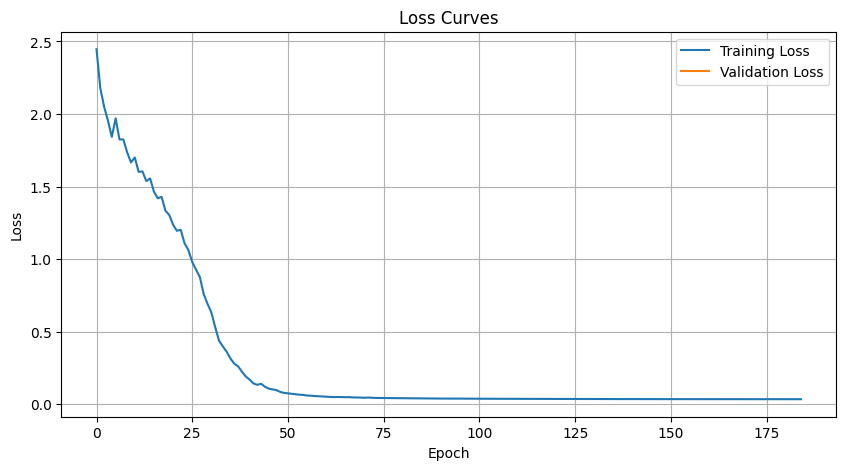

2024-11-18 21:28:45,126 - INFO - Final training loss: 0.0350
2024-11-18 21:28:45,288 - INFO - 提前1天预报 - RMSE: 0.8016, MAE: 0.6182
2024-11-18 21:28:45,293 - INFO - 
训练提前2天预报模型
2024-11-18 21:28:45,296 - INFO - Step 2 - First 5 target values: [[0.15591458]
 [0.16757556]
 [0.171979  ]
 [0.17010346]
 [0.15371286]]
2024-11-18 21:29:04,514 - INFO - Epoch 10/200, Average Loss: 1.3079
2024-11-18 21:29:21,025 - INFO - Epoch 20/200, Average Loss: 0.9982
2024-11-18 21:29:37,322 - INFO - Epoch 30/200, Average Loss: 0.5068
2024-11-18 21:29:54,427 - INFO - Epoch 40/200, Average Loss: 0.1865
2024-11-18 21:30:10,699 - INFO - Epoch 50/200, Average Loss: 0.0806
2024-11-18 21:30:27,079 - INFO - Epoch 60/200, Average Loss: 0.0503
2024-11-18 21:30:45,321 - INFO - Epoch 70/200, Average Loss: 0.0442
2024-11-18 21:31:02,136 - INFO - Epoch 80/200, Average Loss: 0.0416
2024-11-18 21:31:18,785 - INFO - Epoch 90/200, Average Loss: 0.0399
2024-11-18 21:31:36,269 - INFO - Epoch 100/200, Average Loss: 0.0394
2024-11-1

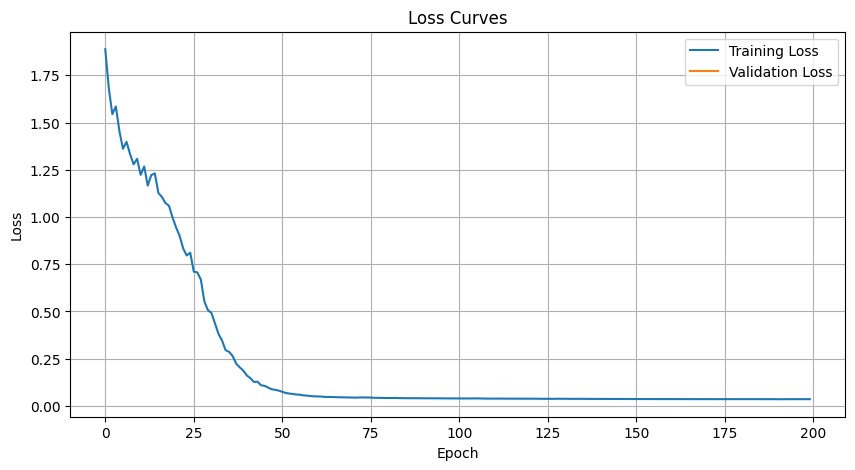

2024-11-18 21:34:42,394 - INFO - Final training loss: 0.0352
2024-11-18 21:34:42,451 - INFO - 提前2天预报 - RMSE: 0.2028, MAE: 0.1664
2024-11-18 21:34:42,452 - INFO - 
训练提前3天预报模型
2024-11-18 21:34:42,453 - INFO - Step 3 - First 5 target values: [[0.16757556]
 [0.171979  ]
 [0.17010346]
 [0.15371286]
 [0.13222568]]
2024-11-18 21:34:58,783 - INFO - Epoch 10/200, Average Loss: 1.1157
2024-11-18 21:35:16,050 - INFO - Epoch 20/200, Average Loss: 0.8801
2024-11-18 21:35:33,406 - INFO - Epoch 30/200, Average Loss: 0.4924
2024-11-18 21:35:50,309 - INFO - Epoch 40/200, Average Loss: 0.1487
2024-11-18 21:36:08,144 - INFO - Epoch 50/200, Average Loss: 0.0647
2024-11-18 21:36:26,711 - INFO - Epoch 60/200, Average Loss: 0.0504
2024-11-18 21:36:46,250 - INFO - Epoch 70/200, Average Loss: 0.0451
2024-11-18 21:37:08,510 - INFO - Epoch 80/200, Average Loss: 0.0425
2024-11-18 21:37:27,414 - INFO - Epoch 90/200, Average Loss: 0.0407
2024-11-18 21:37:44,681 - INFO - Epoch 100/200, Average Loss: 0.0396
2024-11-1

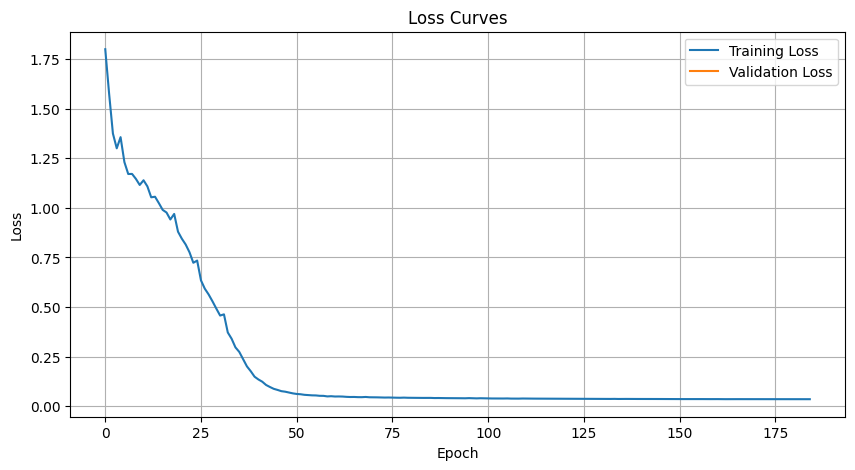

2024-11-18 21:40:11,165 - INFO - Final training loss: 0.0353
2024-11-18 21:40:11,231 - INFO - 提前3天预报 - RMSE: 0.1821, MAE: 0.1342
2024-11-18 21:40:11,232 - INFO - 
训练提前4天预报模型
2024-11-18 21:40:11,234 - INFO - Step 4 - First 5 target values: [[0.171979  ]
 [0.17010346]
 [0.15371286]
 [0.13222568]
 [0.09964834]]
2024-11-18 21:40:30,158 - INFO - Epoch 10/200, Average Loss: 1.3329
2024-11-18 21:40:50,751 - INFO - Epoch 20/200, Average Loss: 1.0518
2024-11-18 21:41:09,644 - INFO - Epoch 30/200, Average Loss: 0.6371
2024-11-18 21:41:26,084 - INFO - Epoch 40/200, Average Loss: 0.1744
2024-11-18 21:41:42,076 - INFO - Epoch 50/200, Average Loss: 0.0772
2024-11-18 21:41:57,546 - INFO - Epoch 60/200, Average Loss: 0.0582
2024-11-18 21:42:14,040 - INFO - Epoch 70/200, Average Loss: 0.0507
2024-11-18 21:42:33,082 - INFO - Epoch 80/200, Average Loss: 0.0481
2024-11-18 21:42:52,177 - INFO - Epoch 90/200, Average Loss: 0.0445
2024-11-18 21:43:09,016 - INFO - Epoch 100/200, Average Loss: 0.0429
2024-11-1

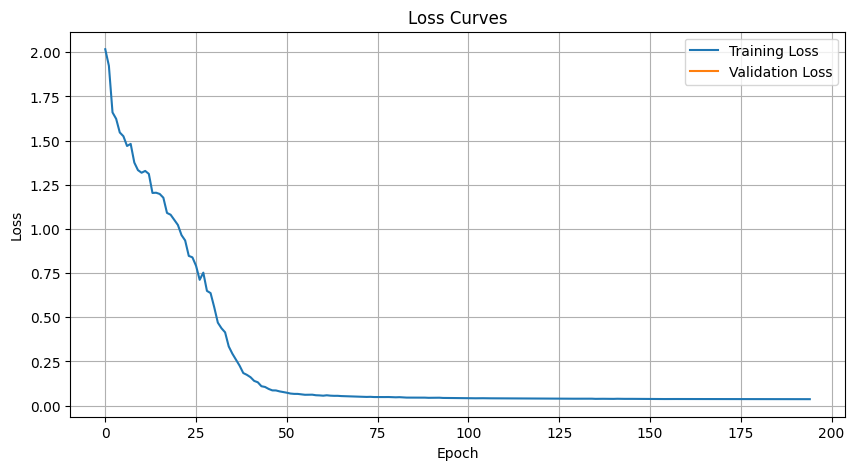

2024-11-18 21:46:07,501 - INFO - Final training loss: 0.0368
2024-11-18 21:46:07,718 - INFO - 提前4天预报 - RMSE: 0.3543, MAE: 0.2656
2024-11-18 21:46:07,720 - INFO - 
训练提前5天预报模型
2024-11-18 21:46:07,722 - INFO - Step 5 - First 5 target values: [[0.17010346]
 [0.15371286]
 [0.13222568]
 [0.09964834]
 [0.0548392 ]]
2024-11-18 21:46:24,385 - INFO - Epoch 10/200, Average Loss: 1.7367
2024-11-18 21:46:41,809 - INFO - Epoch 20/200, Average Loss: 1.3110
2024-11-18 21:47:03,015 - INFO - Epoch 30/200, Average Loss: 0.7652
2024-11-18 21:47:23,071 - INFO - Epoch 40/200, Average Loss: 0.2199
2024-11-18 21:47:43,452 - INFO - Epoch 50/200, Average Loss: 0.0875
2024-11-18 21:48:02,698 - INFO - Epoch 60/200, Average Loss: 0.0540
2024-11-18 21:48:19,243 - INFO - Epoch 70/200, Average Loss: 0.0448
2024-11-18 21:48:35,670 - INFO - Epoch 80/200, Average Loss: 0.0415
2024-11-18 21:48:53,855 - INFO - Epoch 90/200, Average Loss: 0.0404
2024-11-18 21:49:14,600 - INFO - Epoch 100/200, Average Loss: 0.0388
2024-11-1

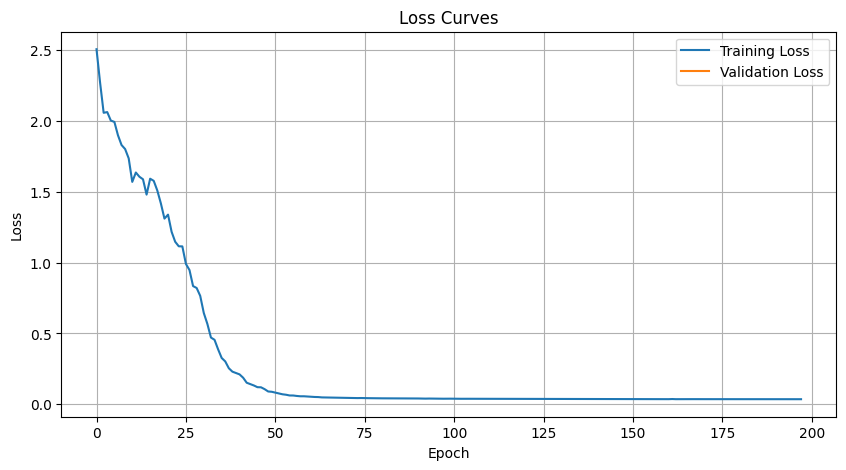

2024-11-18 21:52:01,247 - INFO - Final training loss: 0.0350
2024-11-18 21:52:01,340 - INFO - 提前5天预报 - RMSE: 0.4779, MAE: 0.3625
2024-11-18 21:52:01,341 - INFO - 
训练提前6天预报模型
2024-11-18 21:52:01,342 - INFO - Step 6 - First 5 target values: [[0.15371286]
 [0.13222568]
 [0.09964834]
 [0.0548392 ]
 [0.03751083]]
2024-11-18 21:52:17,119 - INFO - Epoch 10/200, Average Loss: 0.8712
2024-11-18 21:52:33,034 - INFO - Epoch 20/200, Average Loss: 0.6233
2024-11-18 21:52:50,937 - INFO - Epoch 30/200, Average Loss: 0.2952
2024-11-18 21:53:08,261 - INFO - Epoch 40/200, Average Loss: 0.1106
2024-11-18 21:53:24,856 - INFO - Epoch 50/200, Average Loss: 0.0615
2024-11-18 21:53:41,022 - INFO - Epoch 60/200, Average Loss: 0.0460
2024-11-18 21:53:57,819 - INFO - Epoch 70/200, Average Loss: 0.0422
2024-11-18 21:54:13,081 - INFO - Epoch 80/200, Average Loss: 0.0393
2024-11-18 21:54:28,429 - INFO - Epoch 90/200, Average Loss: 0.0384
2024-11-18 21:54:44,117 - INFO - Epoch 100/200, Average Loss: 0.0375
2024-11-1

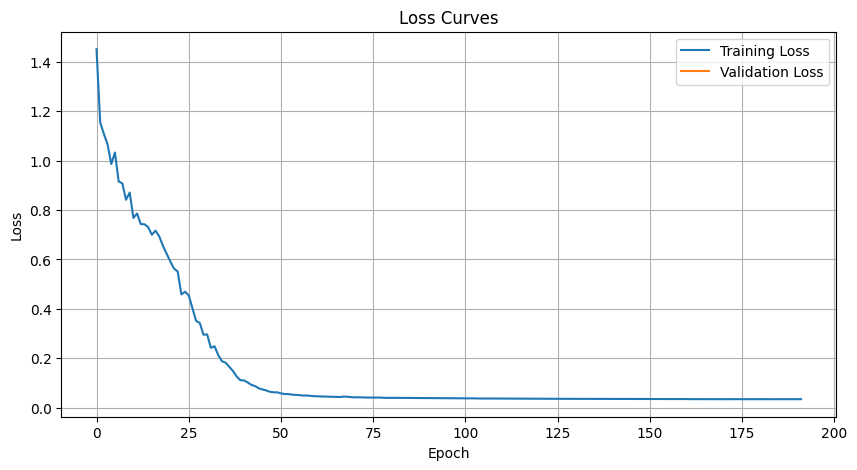

2024-11-18 21:57:10,860 - INFO - Final training loss: 0.0339
2024-11-18 21:57:10,968 - INFO - 提前6天预报 - RMSE: 0.2062, MAE: 0.1738
2024-11-18 21:57:10,971 - INFO - 
训练提前7天预报模型
2024-11-18 21:57:10,974 - INFO - Step 7 - First 5 target values: [[0.13222568]
 [0.09964834]
 [0.0548392 ]
 [0.03751083]
 [0.04464604]]
2024-11-18 21:57:29,207 - INFO - Epoch 10/200, Average Loss: 1.2273
2024-11-18 21:57:49,329 - INFO - Epoch 20/200, Average Loss: 0.9080
2024-11-18 21:58:08,185 - INFO - Epoch 30/200, Average Loss: 0.4845
2024-11-18 21:58:25,142 - INFO - Epoch 40/200, Average Loss: 0.1428
2024-11-18 21:58:41,054 - INFO - Epoch 50/200, Average Loss: 0.0601
2024-11-18 21:58:57,391 - INFO - Epoch 60/200, Average Loss: 0.0460
2024-11-18 21:59:15,257 - INFO - Epoch 70/200, Average Loss: 0.0420
2024-11-18 21:59:31,759 - INFO - Epoch 80/200, Average Loss: 0.0402
2024-11-18 21:59:48,616 - INFO - Epoch 90/200, Average Loss: 0.0393
2024-11-18 22:00:06,133 - INFO - Epoch 100/200, Average Loss: 0.0381
2024-11-1

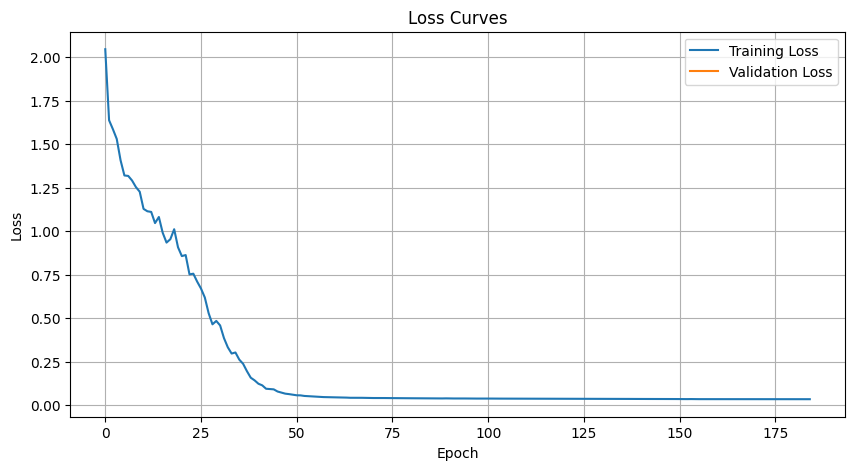

2024-11-18 22:02:22,800 - INFO - Final training loss: 0.0345
2024-11-18 22:02:22,869 - INFO - 提前7天预报 - RMSE: 0.2346, MAE: 0.1824
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7242/2806122970.py:362: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/

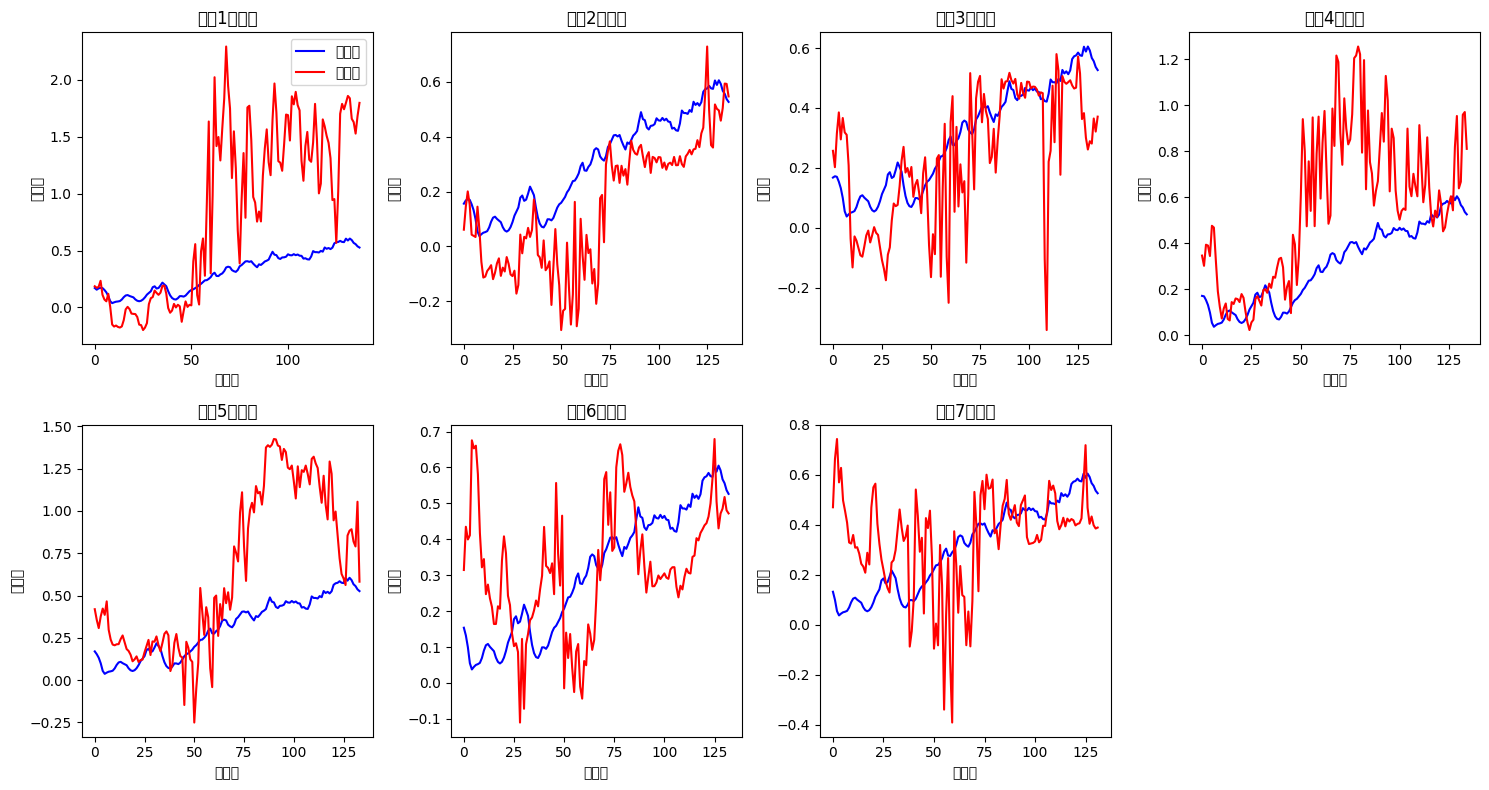

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

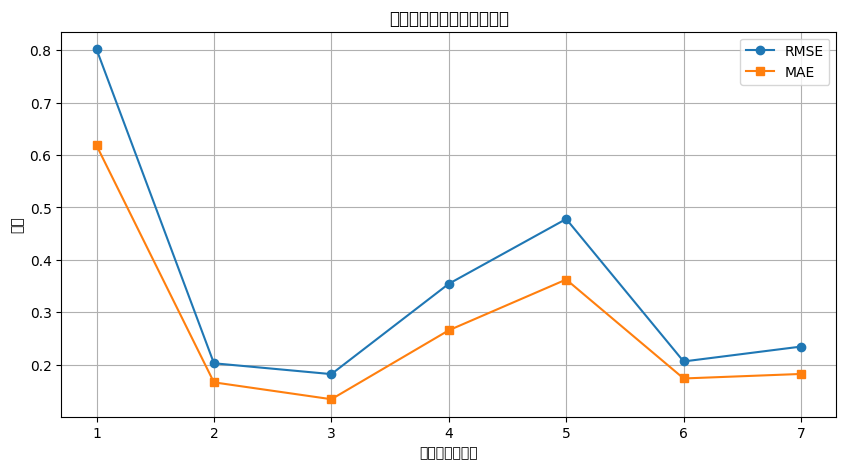

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class WeightedHuberLoss(nn.Module):
    def __init__(self, density_weight=2.0):
        super(WeightedHuberLoss, self).__init__()
        self.base_criterion = nn.HuberLoss()
        self.density_weight = density_weight

    def forward(self, pred, target):
        base_loss = self.base_criterion(pred, target)
        return base_loss * self.density_weight

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, feature_names=None):
        super(LSTMModel, self).__init__()
        
        # 特征权重层，为藻密度相关特征赋予更大权重
        initial_weights = torch.ones(input_size)
        if feature_names:
            density_indices = [i for i, name in enumerate(feature_names) if 'density' in name]
            initial_weights[density_indices] = 2.0  # 藻密度特征权重加倍
        self.feature_weights = nn.Parameter(initial_weights)
        
        # 批归一化层
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向LSTM
        )
        
        # 注意力机制
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)  # *2是因为双向LSTM
        
        # 全连接层，使用多层防止过拟合
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        # 批归一化
        batch_size, seq_len, features = weighted_x.size()
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        weighted_x = weighted_x.transpose(1, 2)
        
        # LSTM处理
        lstm_out, _ = self.lstm(weighted_x)
        
        # 注意力机制
        lstm_out = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.transpose(0, 1)
        
        # 取最后一个时间步
        out = attn_out[:, -1, :]
        
        # 全连接层
        out = self.fc_layers(out)
        
        # 残差连接
        residual = self.residual(weighted_x[:, -1, :])
        out = out + residual
        
        return out

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对藻密度特征进行特殊缩放
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    
    # 使用不同的缩放器分别处理藻密度特征和其他特征
    density_scaler = MinMaxScaler(feature_range=(0.2, 1.0))  # 给予更大的值范围
    other_scaler = MinMaxScaler(feature_range=(0, 0.8))
    
    # 分别缩放
    df_density = df[density_features]
    df_others = df[list(set(all_features) - set(density_features))]
    
    df_density_scaled = pd.DataFrame(
        density_scaler.fit_transform(df_density),
        columns=density_features,
        index=df.index
    )
    
    df_others_scaled = pd.DataFrame(
        other_scaler.fit_transform(df_others),
        columns=df_others.columns,
        index=df.index
    )
    
    # 合并缩放后的数据
    df_scaled = pd.concat([df_density_scaled, df_others_scaled], axis=1)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        # 保持时间顺序
        train_indices = np.arange(len(X_train))
        test_indices = np.arange(len(X_test))
        
        train_data_dict[step] = (X_train[train_indices], y_train[train_indices])
        test_data_dict[step] = (X_test[test_indices], y_test[test_indices])
        
        # 打印验证信息
        logging.info(f"Step {step} - First 5 target values: {y_test[:5]}")
    
    return train_data_dict, test_data_dict, density_scaler, all_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    # 确保数据顺序一致
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # 设置shuffle=False
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = WeightedHuberLoss(density_weight=2.0)  # 使用加权损失函数
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)  # 输入特征维度会增加
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            # 打印验证信息
            logging.info(f"Step {step} - First 5 target values: {y_test[:5]}")
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2, feature_names=features)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()